<a href="https://colab.research.google.com/github/zhouchun0105/Fake-News-Detection-Project-BA865/blob/main/BA865_Fake_News_Classification_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import libraries

In [ ]:
! pip install spacy-universal-sentence-encoder

In [33]:
# imports 
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import spacy
from spacy import cli
from spacy import displacy
import spacy_universal_sentence_encoder

try:
    from scikeras.wrappers import KerasRegressor                     
except ImportError:
    !pip install scikeras
    from scikeras.wrappers import KerasRegressor

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import GridSearchCV

from wordcloud import WordCloud

In [4]:
# Mounting Google Drive locally
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


# Setup and Data Cleaning

In [5]:
# Import data 
df_fakenews_true = pd.read_csv("gdrive/Shared drives/BA865 Group Project/News _dataset/True.csv")
df_fakenews_fake = pd.read_csv("gdrive/Shared drives/BA865 Group Project/News _dataset/Fake.csv")


In [6]:
df_fakenews_true.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [7]:
df_fakenews_fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [8]:
df_fakenews_true.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21417 entries, 0 to 21416
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    21417 non-null  object
 1   text     21417 non-null  object
 2   subject  21417 non-null  object
 3   date     21417 non-null  object
dtypes: object(4)
memory usage: 669.4+ KB


In [9]:
df_fakenews_fake.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    23481 non-null  object
 1   text     23481 non-null  object
 2   subject  23481 non-null  object
 3   date     23481 non-null  object
dtypes: object(4)
memory usage: 733.9+ KB


In [10]:
print(df_fakenews_true.shape)
print(df_fakenews_fake.shape)

(21417, 4)
(23481, 4)


In [11]:
# checking for any null values
df_fakenews_true.isnull().sum()

title      0
text       0
subject    0
date       0
dtype: int64

In [12]:
# checking for any null values
df_fakenews_fake.isnull().sum()

title      0
text       0
subject    0
date       0
dtype: int64

# Data Pre-Processing

In [13]:
# creating new colum 'Real/Fake', labeling the two datasets in order to merge and know which observation is real and which one is false
df_fakenews_true['real/fake'] = '1'
df_fakenews_fake['real/fake'] = '0'

In [14]:
# merging the two datasets
frames = [df_fakenews_true, df_fakenews_fake]
news_data = pd.concat(frames)
news_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44898 entries, 0 to 23480
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   title      44898 non-null  object
 1   text       44898 non-null  object
 2   subject    44898 non-null  object
 3   date       44898 non-null  object
 4   real/fake  44898 non-null  object
dtypes: object(5)
memory usage: 2.1+ MB


In [15]:
news_data.head()

,title,text,subject,date,real/fake
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1


In [16]:
# date column Split to see if there are seasonal trends
# splitting the Year, the Month and Day Data
date_split1 = news_data['date'].str.split(',', expand=True)
news_data['Year'] = date_split1[1]

date_split2 = news_data['date'].str.split(' ', expand=True)
news_data['Month'] = date_split2[0]
news_data['Day'] = date_split2[1]
news_data['Day'] = news_data['Day'].replace(',','', regex=True)


In [17]:
# dropping date column 
news_data = news_data.drop('date', axis=1)
news_data.head()

,title,text,subject,real/fake,Year,Month,Day
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,1,2017,December,31
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,1,2017,December,29
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,1,2017,December,31
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,1,2017,December,30
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,1,2017,December,29


In [18]:
news_data.describe()

,title,text,subject,real/fake,Year,Month,Day
count,44898,44898,44898,44898,44853,44898,44854
unique,38729,38646,8,2,5,35,32
top,Factbox: Trump fills top jobs for his administ...,,politicsNews,0,2017,November,13
freq,14,627,11272,23481,16701,4388,1651


In [19]:
# one-hot encoding for subject column
news_data = pd.get_dummies(news_data, columns=["subject"])

In [20]:
# title and text can be two seperate variables
news_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44898 entries, 0 to 23480
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   title                    44898 non-null  object
 1   text                     44898 non-null  object
 2   real/fake                44898 non-null  object
 3   Year                     44853 non-null  object
 4   Month                    44898 non-null  object
 5   Day                      44854 non-null  object
 6   subject_Government News  44898 non-null  uint8 
 7   subject_Middle-east      44898 non-null  uint8 
 8   subject_News             44898 non-null  uint8 
 9   subject_US_News          44898 non-null  uint8 
 10  subject_left-news        44898 non-null  uint8 
 11  subject_politics         44898 non-null  uint8 
 12  subject_politicsNews     44898 non-null  uint8 
 13  subject_worldnews        44898 non-null  uint8 
dtypes: object(6), uint8(8)
memory usage: 2

# EDA

(-0.5, 1299.5, 949.5, -0.5)

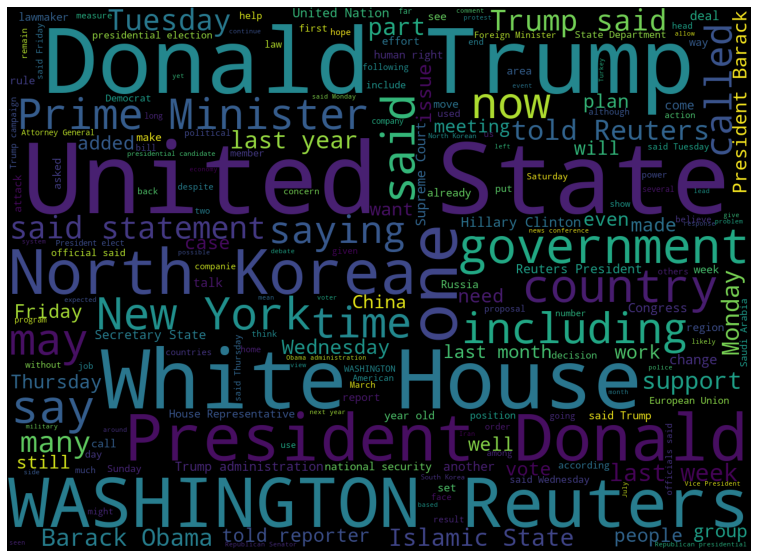

In [21]:
# word cloud for the text real true News
text_true = pd.Series(df_fakenews_true['text'].tolist()).astype(str)

cloud = WordCloud(width=1300, height=950).generate(" ".join(text_true.astype(str)))
plt.figure(figsize=(15, 10))
plt.imshow(cloud)
plt.axis('off')

(-0.5, 1299.5, 949.5, -0.5)

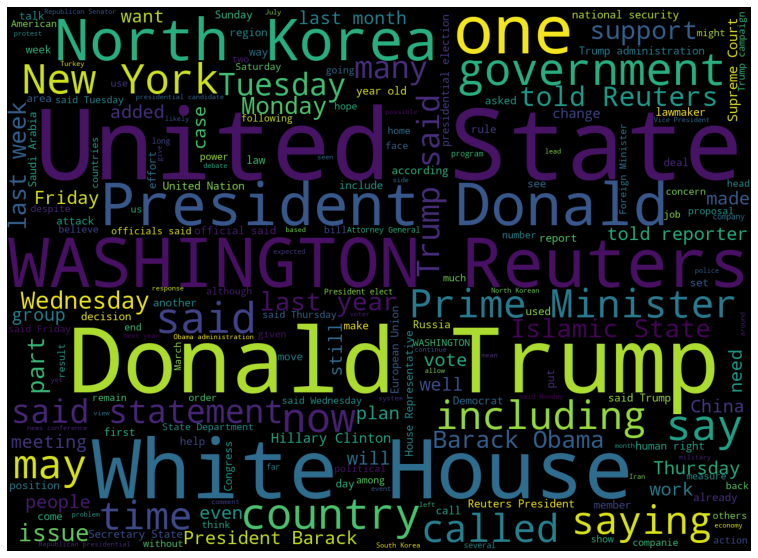

In [22]:
# word cloud for the text false fake News
text_false = pd.Series(df_fakenews_true['text'].tolist()).astype(str)

cloud = WordCloud(width=1300, height=950).generate(" ".join(text_false.astype(str)))
plt.figure(figsize=(15, 10))
plt.imshow(cloud)
plt.axis('off')

In [45]:
#plot to see Counts of Real and Fake data
total = float(len(news_data)

fig = sns.countplot(x='real/fake', data = news_data)
plt.title("Count of Real and Fake Data", fontsize=20)

for p in fig.patches:
    fig.annotate(format(int(p.get_height())), 
                   (p.get_x() + p.get_width() / 2, p.get_height()), 
                   ha = 'center', va = 'center', 
                   size=10,
                   xytext = (0, -10), 
                   textcoords = 'offset points')
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width()
    y = p.get_height()
    fig.annotate(percentage, (x, y),ha='center')

SyntaxError: ignored

# Feature Engineering/Natural Language Processing 


*   TfiDf Vectorizer
*   SpaCy
*   Work Tokenizer



## TfiDf Vectorizer

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
import spacy
from spacy import cli

In [ ]:
model = "en_core_web_sm"
cli.download(model)
EXCL = ['tagger', 'parser', 'attribute_ruler', 'lemmatizer', 'ner']
#text processing
nlp = spacy.load(model, disable=EXCL)
nlp.pipe_names
docs = list(nlp.pipe(news_data.text, disable=EXCL))
#getting the document vectors
dv = [doc.vector for doc in docs]
dv = np.array(dv)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
vect=CountVectorizer()

In [ ]:
from sklearn.compose import make_column_transformer
ct = make_column_transformer((vect,news_data.text),(vect, news_data.title))

In [ ]:
ct

## SpaCy

In [ ]:
# get spacy model
model = "en_core_web_lg"
cli.download(model)

nlp = spacy.load(model)

In [ ]:
# the pipeline
nlp.pipe_names

In [ ]:
#add the pipe
nlp.add_pipe('universal_sentence_encoder', config={'enable_cache': False, 'model_name':'en_use_md'})

# Deep Learning/Tenserflow